<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Code/Random_forests_pretrained_CNN_Poly_habitat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random forest classifiers**

This script splits the data into the same train/val/test sets as used for the pretrained CNN and trained CNN. It then trains on the training data and generates the accuracy for the validation data 50 times. The best performing model of the 50 repeats is used to inference on the test data and this accuracy is reported. This proces is repeated 32 times to generate an accuracyfor all train/val/test split combinations. A confusion matrix of all these is then generated.

In [6]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# imports, probably some redundant packages
from __future__ import division

import sklearn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.model_selection import train_test_split
import statistics

from sklearn.metrics import confusion_matrix

import collections
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
# Upload the csv of features and copy the path
path = r'/content/drive/MyDrive/Reef soundscapes with AI/Results/full_dataset_features/pretrained_CNN_poly.csv'
num_classes = 2
labels = ['Photic', 'Mesophotic']

In [7]:
data = pd.read_csv (path)
df = data.reset_index() 
df = df.iloc[: , 2:] #remove additional indata = pd.read_csv (path) #load dataframe
temp_df = data.reset_index() #put index in order
temp_df = temp_df.iloc[: , 2:] #remove unnecessary index
temp_df = temp_df.T #transpose to match indices format
temp_df = temp_df.reset_index() #re-add the index
df = temp_df.rename(columns={"index": "minute"})

df

,minute,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,SiteCDay3.805322778.210303214058.wav,0.024271,0.015441,0.673868,0.015810,0.000000,0.0,0.0,0.013191,0.0,...,0.0,0.075812,0.079045,0.000000,0.164519,0.160550,0.027020,0.000000,0.000133,0.001901
1,SiteXDay3.5210.210215103530.wav,0.024545,0.001385,0.885764,0.007736,0.000000,0.0,0.0,0.003682,0.0,...,0.0,0.054833,0.031658,0.000000,0.210327,0.050721,0.043802,0.000000,0.000000,0.000000
2,SiteYDay2.5210.210302223537.wav,0.038698,0.000000,0.621418,0.045740,0.000000,0.0,0.0,0.029869,0.0,...,0.0,0.042964,0.068022,0.000000,0.006417,0.156122,0.001582,0.000000,0.000000,0.000000
3,SiteDDay2.5210.210317091056.wav,0.011494,0.099208,0.532689,0.007028,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.006671,0.003732,0.000000,0.039698,0.226014,0.066506,0.000000,0.001176,0.000000
4,SiteADay3.805322778.210205190014.wav,0.000000,0.084872,0.072530,0.075937,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.023012,0.000000,0.000000,0.237829,0.050223,0.057576,0.000000,0.000000,0.008781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,SiteDDay3.5210.210317141559.wav,0.011558,0.052947,0.591418,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.007208,0.003910,0.000000,0.030538,0.202830,0.018578,0.000000,0.000000,0.000000
8972,SiteBDay2.805322778.210214103515.wav,0.001393,0.066229,0.398799,0.149027,0.000000,0.0,0.0,0.000777,0.0,...,0.0,0.053009,0.007668,0.000623,0.001218,0.297432,0.215393,0.000000,0.000000,0.000000
8973,SiteZDay1.805322778.210315152558.wav,0.020564,0.101476,0.334346,0.159136,0.000654,0.0,0.0,0.016787,0.0,...,0.0,0.068794,0.025673,0.000000,0.000000,0.264537,0.285786,0.011261,0.000000,0.000525
8974,SiteADay3.805322778.210206002517.wav,0.000000,0.199585,0.116687,0.252471,0.000000,0.0,0.0,0.000073,0.0,...,0.0,0.000000,0.000000,0.000000,0.028089,0.093403,0.154533,0.000000,0.000076,0.006282


In [8]:
def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    site = filename[0:5]
    return site
    
df_withclasses = df

# add a column to the DF that contains class
new_list = []
for i in range(len(df_withclasses)):
    new_list.append(get_class(df_withclasses['minute'][i]))

df_withclasses.insert(1, 'Class', new_list)
#df_withclasses.head(20)

pretrained_df = df_withclasses 


# Rename the renaming sites to mesophotic or photic fish
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteA'],'Photic')
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteB'],'Photic')
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteC'],'Photic')
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteD'],'Photic')

pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteW'],'Mesophotic')
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteX'],'Mesophotic')
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteY'],'Mesophotic')
pretrained_df['Class'] = pretrained_df['Class'].replace(['SiteZ'],'Mesophotic')

pretrained_df.reset_index(drop=True, inplace=True)
pretrained_df.head()

,minute,Class,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,SiteCDay3.805322778.210303214058.wav,Photic,0.024271,0.015441,0.673868,0.015810,0.0,0.0,0.0,0.013191,...,0.0,0.075812,0.079045,0.0,0.164519,0.160550,0.027020,0.0,0.000133,0.001901
1,SiteXDay3.5210.210215103530.wav,Mesophotic,0.024545,0.001385,0.885764,0.007736,0.0,0.0,0.0,0.003682,...,0.0,0.054833,0.031658,0.0,0.210327,0.050721,0.043802,0.0,0.000000,0.000000
2,SiteYDay2.5210.210302223537.wav,Mesophotic,0.038698,0.000000,0.621418,0.045740,0.0,0.0,0.0,0.029869,...,0.0,0.042964,0.068022,0.0,0.006417,0.156122,0.001582,0.0,0.000000,0.000000
3,SiteDDay2.5210.210317091056.wav,Photic,0.011494,0.099208,0.532689,0.007028,0.0,0.0,0.0,0.000000,...,0.0,0.006671,0.003732,0.0,0.039698,0.226014,0.066506,0.0,0.001176,0.000000
4,SiteADay3.805322778.210205190014.wav,Photic,0.000000,0.084872,0.072530,0.075937,0.0,0.0,0.0,0.000000,...,0.0,0.023012,0.000000,0.0,0.237829,0.050223,0.057576,0.0,0.000000,0.008781


In [9]:
def similar(x,y):
    si = 0
    for a,b in zip(x, y):
        if a == b:
            si += 1
    return (si/len(x)) * 100

def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    site = filename[0:5]
    return site
    
df_withclasses = df

# add a column to the DF that contains class
new_list = []
for i in range(len(df_withclasses)):
    new_list.append(get_class(pretrained_df['minute'][i]))

pretrained_df.insert(1, 'Site', new_list)
pretrained_df

,minute,Site,Class,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,SiteCDay3.805322778.210303214058.wav,SiteC,Photic,0.024271,0.015441,0.673868,0.015810,0.000000,0.0,0.0,...,0.0,0.075812,0.079045,0.000000,0.164519,0.160550,0.027020,0.000000,0.000133,0.001901
1,SiteXDay3.5210.210215103530.wav,SiteX,Mesophotic,0.024545,0.001385,0.885764,0.007736,0.000000,0.0,0.0,...,0.0,0.054833,0.031658,0.000000,0.210327,0.050721,0.043802,0.000000,0.000000,0.000000
2,SiteYDay2.5210.210302223537.wav,SiteY,Mesophotic,0.038698,0.000000,0.621418,0.045740,0.000000,0.0,0.0,...,0.0,0.042964,0.068022,0.000000,0.006417,0.156122,0.001582,0.000000,0.000000,0.000000
3,SiteDDay2.5210.210317091056.wav,SiteD,Photic,0.011494,0.099208,0.532689,0.007028,0.000000,0.0,0.0,...,0.0,0.006671,0.003732,0.000000,0.039698,0.226014,0.066506,0.000000,0.001176,0.000000
4,SiteADay3.805322778.210205190014.wav,SiteA,Photic,0.000000,0.084872,0.072530,0.075937,0.000000,0.0,0.0,...,0.0,0.023012,0.000000,0.000000,0.237829,0.050223,0.057576,0.000000,0.000000,0.008781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,SiteDDay3.5210.210317141559.wav,SiteD,Photic,0.011558,0.052947,0.591418,0.000000,0.000000,0.0,0.0,...,0.0,0.007208,0.003910,0.000000,0.030538,0.202830,0.018578,0.000000,0.000000,0.000000
8972,SiteBDay2.805322778.210214103515.wav,SiteB,Photic,0.001393,0.066229,0.398799,0.149027,0.000000,0.0,0.0,...,0.0,0.053009,0.007668,0.000623,0.001218,0.297432,0.215393,0.000000,0.000000,0.000000
8973,SiteZDay1.805322778.210315152558.wav,SiteZ,Mesophotic,0.020564,0.101476,0.334346,0.159136,0.000654,0.0,0.0,...,0.0,0.068794,0.025673,0.000000,0.000000,0.264537,0.285786,0.011261,0.000000,0.000525
8974,SiteADay3.805322778.210206002517.wav,SiteA,Photic,0.000000,0.199585,0.116687,0.252471,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.028089,0.093403,0.154533,0.000000,0.000076,0.006282


In [10]:
all_saved_test_accs = []
whole_site_saved_test_accs = []
ConfusionMatrix = np.zeros((num_classes, num_classes), dtype=float)

for i in range(4):  #4 sites in the photicfish class
  photic = ['SiteA', 'SiteB', 'SiteC', 'SiteD'] #the 4 photic fish sites
  remove_photic = photic[i] #select 1 to be the val site
  train_photic = photic 
  train_photic.remove(remove_photic) #remove the val site to get the train photicfish sites
  #print(train_photic)
  for k in range(4): #4 sites in the mesophoticfish class
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []

    mesophotic = ['SiteW', 'SiteX', 'SiteY', 'SiteZ'] #the 4 mesophotic fish sites
    remove_mesophotic = mesophotic[k] #select 1 to be the test site
    train_mesophotic = mesophotic 
    train_mesophotic.remove(remove_mesophotic) #remove the test site to get the train photicfish sites
    #print(train_mesophotic)
    
    # Make the train df's, starting with photic fish then append mesophotic fish
    train_df = pretrained_df.loc[pretrained_df['Site'].isin(train_photic)]
    train_df = train_df.append(pretrained_df.loc[pretrained_df['Site'].isin(train_mesophotic)])

    # create val df that is 50:50 photic and mesophotic fish
    photicfish_df = pretrained_df.loc[pretrained_df['Site'] == remove_photic]
    mesophoticfish_df = pretrained_df.loc[pretrained_df['Site'] == remove_mesophotic]
    val_df = photicfish_df.iloc[::2,:] # take every other photicfish minute and create a new df
    val_df = val_df.append(mesophoticfish_df.iloc[::2,:])
    # create test df's that is the ramaining 50:50 photic and mesophotic fish
    test_df = photicfish_df.iloc[1::2,:] # take every other photicfish minute and create a new df
    test_df = test_df.append(mesophoticfish_df.iloc[1::2,:])

    #shuffle the df's so the RF's aren't first fed all photic then fed all mesophotic fish after
    np.random.seed(123) 
    train_df = train_df.sample(frac=1)
    val_df = val_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    np.random.seed() #now lift the seed so that randomisation can be used again in the rest of the script

    # Make new df's of the feats and labels to feed random forests
    train_feats = train_df.iloc[:, 3:].to_numpy()
    train_labels = train_df.iloc[:, 2].to_numpy()

    val_feats = val_df.iloc[:, 3:].to_numpy()
    val_labels = val_df.iloc[:, 2].to_numpy()

    test_feats = test_df.iloc[:, 3:].to_numpy()
    test_labels = test_df.iloc[:, 2].to_numpy()

    
    val_accuracy_score = 0
    for k in range(50):              # Picked 50 as 50 epochs used in NN
      #Training on train data
      model = RandomForestClassifier(n_jobs = -1, random_state=k)
      model.fit(train_feats, train_labels)

      #Inferencing on validation data
      new_val_acc = model.score(val_feats, val_labels)

      #If val acc improved, inference on test data
      if new_val_acc >  val_accuracy_score:
        #save the new mesophotic score for val
        val_accuracy_score = new_val_acc 

        #get 1min acc for test data
        test_acc = model.score(test_feats, test_labels) 
        
        #get the acc when using the most common prediction across all minutes in a day for each site
        test_predictions = model.predict(test_feats)

        # get confusion matrix values
        best_ConfusionMatrix = confusion_matrix(test_labels, test_predictions, labels = labels) ###

        #acc = 0 
        #for i in range(num_classes):
          # max = np.amax(best_ConfusionMatrix[i])
          #if max == best_ConfusionMatrix[i,i]:
            # acc += 1
            #whole_day_acc = acc/num_classes
        #print(similar(test_labels, test_predictions))
        if  similar(test_labels, test_predictions) >= 50:
          whole_site_acc = 1
        else:
          whole_site_acc = 0
        
      
    #Save best results
    ConfusionMatrix = np.add(ConfusionMatrix, best_ConfusionMatrix) ###
    thisCV_saved_test_accs.append(test_acc)
    all_saved_test_accs.append(test_acc)
    thisCV_saved_test_day_accs.append(whole_site_acc)
    whole_site_saved_test_accs.append(whole_site_acc)

    print('Accuracies for 1min files from this site:')
    print(thisCV_saved_test_accs)
    print('Accuracies for the whole site [0 or 1]:')
    print(thisCV_saved_test_day_accs)
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []
    print()




pt1_saved_test_accs = all_saved_test_accs
pt1_whole_site_saved_test_accs = whole_site_saved_test_accs


# this will run all the lowfish sites as val, then repeat the whole thing below but swap the highfish to be in the top loop and low fish in bottom loop
    
    
print('Part 1 Completed RFs:')
print(len(all_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(all_saved_test_accs)
stdev = np.std(all_saved_test_accs)

print('1min saved_test_accs: ')
print(all_saved_test_accs)
result = 'Mean accuracy for 1min files with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result)     



print('Part 1 Completed RFs:')
print(len(whole_site_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(whole_site_saved_test_accs)
stdev = np.std(whole_site_saved_test_accs)

print('Whole site saved test_accs: ')
print(whole_site_saved_test_accs)
result = 'Mean accuracy for whole sites with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result)


all_saved =  mean_accuracy
stdev_pt1 = stdev





all_saved_test_accs = []
whole_site_saved_test_accs = []
#ConfusionMatrix = np.zeros((num_classes, num_classes), dtype=float)

for i in range(4):  #4 sites in the photicfish class
  mesophotic =  ['SiteA', 'SiteB', 'SiteC', 'SiteD'] #the 4 mesophotic fish sites
  remove_mesophotic = mesophotic[i] #select 1 to be the val site
  train_mesophotic = mesophotic 
  train_mesophotic.remove(remove_mesophotic) #remove the val site to get the train photicfish sites
  #print(train_photic)
  for k in range(4): #4 sites in the mesophoticfish class
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []

    photic = ['SiteW', 'SiteX', 'SiteY', 'SiteZ'] #the 4 photic fish sites
    remove_photic = photic[k] #select 1 to be the test site
    train_photic = photic 
    train_photic.remove(remove_photic) #remove the test site to get the train photicfish sites
    #print(train_mesophotic)
    
    # Make the train df's, starting with photic fish then append mesophotic fish
    train_df = pretrained_df.loc[pretrained_df['Site'].isin(train_photic)]
    train_df = train_df.append(pretrained_df.loc[pretrained_df['Site'].isin(train_mesophotic)])

    # create val df that is 50:50 photic and mesophotic fish
    photicfish_df = pretrained_df.loc[pretrained_df['Site'] == remove_photic]
    mesophoticfish_df = pretrained_df.loc[pretrained_df['Site'] == remove_mesophotic]
    val_df = photicfish_df.iloc[::2,:] # take every other photicfish minute and create a new df
    val_df = val_df.append(mesophoticfish_df.iloc[::2,:])
    # create test df's that is the ramaining 50:50 photic and mesophotic fish
    test_df = photicfish_df.iloc[1::2,:] # take every other photicfish minute and create a new df
    test_df = test_df.append(mesophoticfish_df.iloc[1::2,:])

    #shuffle the df's so the RF's aren't first fed all photic then fed all mesophotic fish after
    np.random.seed(123) 
    train_df = train_df.sample(frac=1)
    val_df = val_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    np.random.seed() #now lift the seed so that randomisation can be used again in the rest of the script

    # Make new df's of the feats and labels to feed random forests
    train_feats = train_df.iloc[:, 3:].to_numpy()
    train_labels = train_df.iloc[:, 2].to_numpy()

    val_feats = val_df.iloc[:, 3:].to_numpy()
    val_labels = val_df.iloc[:, 2].to_numpy()

    test_feats = test_df.iloc[:, 3:].to_numpy()
    test_labels = test_df.iloc[:, 2].to_numpy()

    
    val_accuracy_score = 0
    for k in range(50):              # Picked 50 as 50 epochs used in NN
      #Training on train data
      model = RandomForestClassifier(n_jobs = -1, random_state=k)
      model.fit(train_feats, train_labels)

      #Inferencing on validation data
      new_val_acc = model.score(val_feats, val_labels)

      #If val acc improved, inference on test data
      if new_val_acc >  val_accuracy_score:
        #save the new mesophotic score for val
        val_accuracy_score = new_val_acc 

        #get 1min acc for test data
        test_acc = model.score(test_feats, test_labels) 
        
        #get the acc when using the most common prediction across all minutes in a day for each site
        test_predictions = model.predict(test_feats)

        # get confusion matrix values
        best_ConfusionMatrix = confusion_matrix(test_labels, test_predictions, labels = labels) ###

        #acc = 0 
        #for i in range(num_classes):
          # max = np.amax(best_ConfusionMatrix[i])
          #if max == best_ConfusionMatrix[i,i]:
            # acc += 1
            #whole_day_acc = acc/num_classes
        #print(similar(test_labels, test_predictions))
        if  similar(test_labels, test_predictions) >= 50:
          whole_site_acc = 1
        else:
          whole_site_acc = 0
        
      
    #Save best results
    ConfusionMatrix = np.add(ConfusionMatrix, best_ConfusionMatrix) ###
    thisCV_saved_test_accs.append(test_acc)
    all_saved_test_accs.append(test_acc)
    thisCV_saved_test_day_accs.append(whole_site_acc)
    whole_site_saved_test_accs.append(whole_site_acc)

    print('Accuracies for 1min files from this site:')
    print(thisCV_saved_test_accs)
    print('Accuracies for the whole site [0 or 1]:')
    print(thisCV_saved_test_day_accs)
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []
    print()




both_saved_test_accs = pt1_saved_test_accs + all_saved_test_accs 
both_whole_site_saved_test_accs = pt1_whole_site_saved_test_accs + whole_site_saved_test_accs
    
print('Part 2 Completed RFs:')
print(len(both_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(both_saved_test_accs)
stdev = np.std(both_saved_test_accs)

print('1min saved_test_accs: ')
print(both_saved_test_accs)
result = 'Mean accuracy for 1min files with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result) 




print('Part 2 Completed RFs:')
print(len(both_whole_site_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(both_whole_site_saved_test_accs)
stdev = np.std(both_whole_site_saved_test_accs)

print('Whole site saved test_accs: ')
print(both_whole_site_saved_test_accs)
result = 'Mean accuracy for whole sites with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result) 

print()
print(repr(ConfusionMatrix))


Accuracies for 1min files from this site:
[0.9885167464114832]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.9716376944190301]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.9871912168344007]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.5507776761207686]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.9317561419472248]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.8526591107236269]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.9503051438535309]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.6721883173496077]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.462238398544131]
Accuracies for the whole site [0 or 1]:
[0]

Accuracies for 1min files fro

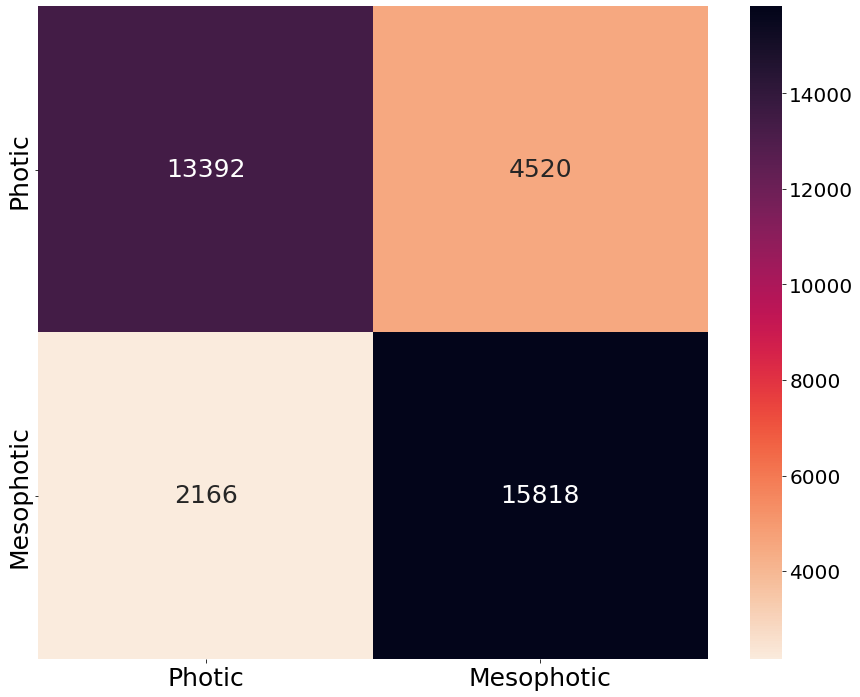

In [12]:
#HPCConfusionMatrix = [[13392.,  4520.],
       [  2166., 15818.]]
      
array = ConfusionMatrix
df_cm = pd.DataFrame(array, index = ["Photic", "Mesophotic"],
                  columns = ["Photic", "Mesophotic"])
plt.figure(figsize = (15,12))
cmap = sn.cm.rocket_r
ax = sn.heatmap(df_cm, annot=True, annot_kws={"fontsize":25}, fmt='g', cmap = cmap)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 25)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 25)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)